In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
df = pd.read_csv("~/Downloads/abcnews-date-text.csv",error_bad_lines=False,warn_bad_lines=False)
df.head()

,<!DOCTYPE html>
0,"<html lang=""en"">"
1,<head>
2,"<meta charset=""utf-8"">"
3,"<link rel=""dns-prefetch"" href=""https://asset..."
4,"<link rel=""dns-prefetch"" href=""https://avata..."


In [3]:
df.shape

(1040322, 2)

In [4]:
df.publish_date = pd.to_datetime(df.publish_date,format="%Y%m%d")

In [5]:
df.publish_date.min(),df.publish_date.max()

(Timestamp('2003-02-19 00:00:00'), Timestamp('2017-07-21 00:00:00'))

In [6]:
df.publish_date.max() - df.publish_date.min()

Timedelta('5266 days 00:00:00')

In [7]:
len(df.publish_date.unique())

5142

In [8]:
s = df.groupby('publish_date').tail(2)

In [9]:
s.head()

,publish_date,headline_text
196,2003-02-19,wine chief bounces back from sacking
197,2003-02-19,worksafe probes potato harvester injuries
446,2003-02-20,yacht loses mast in trawler incident
447,2003-02-20,zimbabwe bars british reporter from world cup
696,2003-02-21,workers return to work on burrup


In [10]:
all_headlines = s.headline_text.values

## Get the sentiment for each headline and list positive , negative and neutral headlines separately

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.corpus import stopwords
StopWords = stopwords.words("english")
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [12]:
%%time
sia = SIA()
pos_list = []
neg_list = []
neu_list = []
for post in all_headlines:
    post = " ".join([stemmer.stem(word) for word in str(post).lower().split() if word not in set(StopWords)])
    res = sia.polarity_scores(post)
    if res['compound'] > 0.0:
        pos_list.append(post)
    elif res['compound'] < 0.0:
        neg_list.append(post)
    else:
        neu_list.append(post)

CPU times: user 4.1 s, sys: 42.5 ms, total: 4.14 s
Wall time: 4.16 s


In [13]:
print("Number of Positive Headlines : {}\nNumber of Negative Headlines : {}\nNumber of Neutral Headlines : {}".format(len(pos_list),len(neg_list),len(neu_list)))

Number of Positive Headlines : 1737
Number of Negative Headlines : 3002
Number of Neutral Headlines : 5490


In [14]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [15]:
pos_words = []
for line in pos_list:
    words = tokenizer.tokenize(line)
    for w in words:
        pos_words.append(w.lower())
    
    

In [16]:
neg_words = []
for line in neg_list:
    words = tokenizer.tokenize(line)
    for w in words:
        neg_words.append(w.lower())

## Most common positive words in the headlines

In [17]:
from nltk import FreqDist
pos_words = FreqDist(pos_words)
for x in pos_words.most_common(10):
    print(x[0],":",x[1])

win : 260
world : 187
young : 165
youth : 111
zimbabw : 74
help : 68
share : 64
award : 56
boost : 53
hope : 52


## Most common negative words in the headlines

In [18]:
neg_words = FreqDist(neg_words)
for x in neg_words.most_common(10):
    print(x[0],":",x[1])

woman : 583
young : 257
world : 185
youth : 180
die : 177
zimbabw : 168
kill : 153
death : 146
crash : 130
worker : 129


## Distribution of words in Positive Headlines

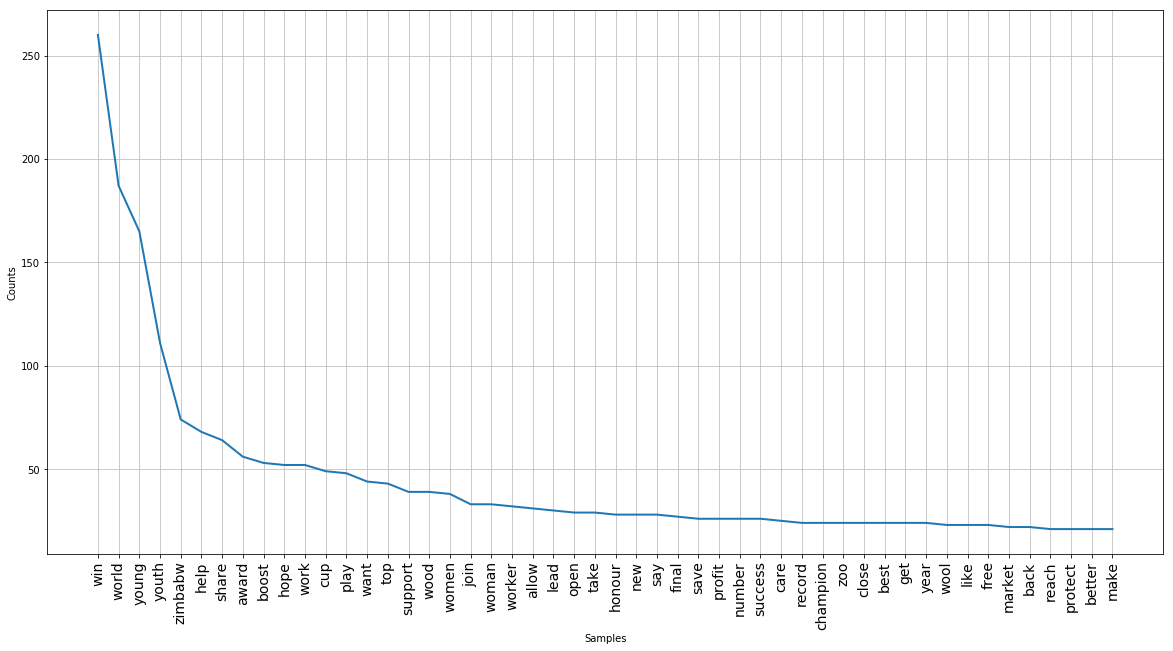

In [19]:
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
matplotlib.rcParams['xtick.labelsize'] = 14
plt.figure(figsize=(20,10))
pos_words.plot(50,cumulative=False)

## Distribution of words in Negative Headlines

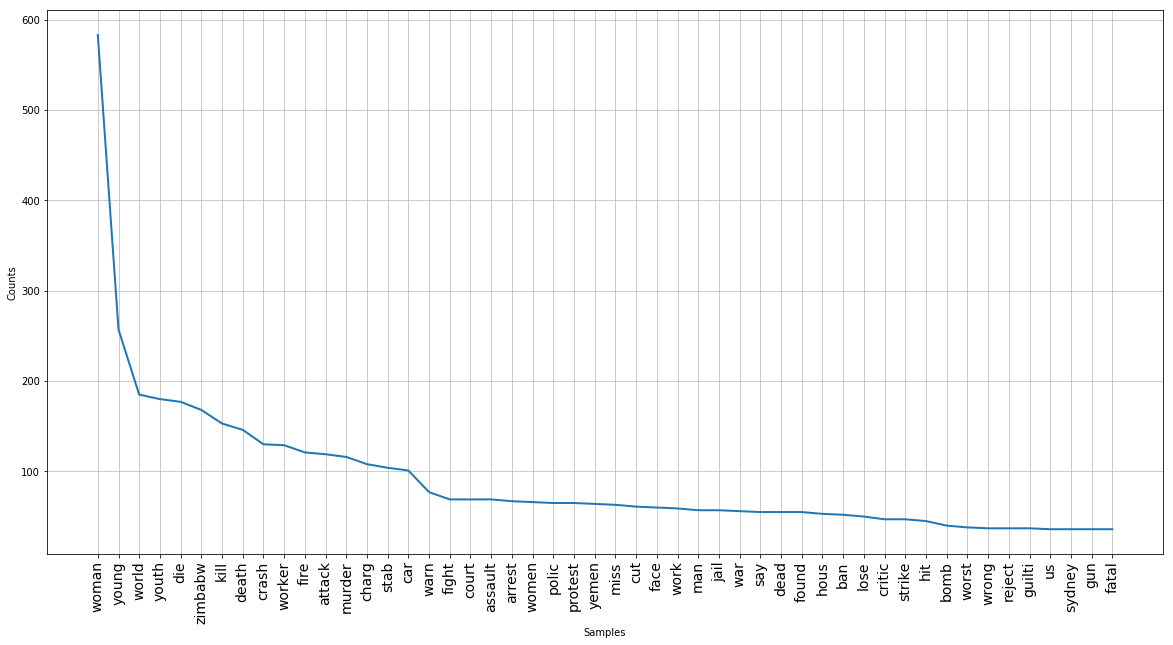

In [20]:
plt.figure(figsize=(20,10))
neg_words.plot(50,cumulative=False)

####  The distribution is as expected, few words repeated most of the times in both positive and negative headlines. The frequency in case of Positive words dips quickly than Negative words

## NEXT UP : CLUSTERING INTO TOPICS

In [21]:
sample = pos_list+neg_list+neu_list

### Load gensim package for LDA and create a document-term matrix out of the headlines

In [22]:
import gensim
from gensim import corpora

sample_clean = [text.split() for text in sample] 

In [23]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(sample_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in sample_clean]

### Fit a LDA model for the document-term matrix, number of topics is set to be 10. 
### If you have only few documents increasing passes might help and if the documents are small (sparse) increasing iterations should help

In [24]:
%%time
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
num_topics = 10
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=50,iterations=100)

CPU times: user 5min 27s, sys: 387 ms, total: 5min 28s
Wall time: 5min 28s


### Get the Document-Topic distribution and Topic-Word distributions

In [25]:
dtm = ldamodel.get_document_topics(doc_term_matrix)
K = ldamodel.num_topics
topic_word_matrix = ldamodel.print_topics(K)

In [26]:
print("The topics are: \n")
for x in topic_word_matrix:
    print(x[0],":",x[1],"\n")

The topics are: 

0 : 0.045*"work" + 0.035*"youth" + 0.015*"start" + 0.014*"call" + 0.013*"plan" + 0.012*"begin" + 0.011*"chang" + 0.011*"mine" + 0.011*"worker" + 0.009*"centr" 

1 : 0.018*"woman" + 0.015*"worker" + 0.012*"fall" + 0.012*"world" + 0.012*"price" + 0.012*"first" + 0.010*"wine" + 0.010*"week" + 0.009*"wrap" + 0.009*"woolworth" 

2 : 0.022*"new" + 0.015*"yemen" + 0.014*"farmer" + 0.013*"90" + 0.013*"continu" + 0.012*"use" + 0.011*"zimbabw" + 0.010*"west" + 0.010*"busi" + 0.009*"york" 

3 : 0.045*"young" + 0.036*"world" + 0.019*"weather" + 0.018*"second" + 0.016*"peopl" + 0.012*"art" + 0.011*"found" + 0.010*"say" + 0.010*"australian" + 0.010*"trump" 

4 : 0.025*"world" + 0.015*"hit" + 0.014*"time" + 0.013*"young" + 0.013*"south" + 0.013*"run" + 0.011*"record" + 0.011*"water" + 0.011*"market" + 0.010*"close" 

5 : 0.035*"zimbabw" + 0.022*"young" + 0.013*"win" + 0.012*"india" + 0.010*"elect" + 0.010*"beat" + 0.010*"tour" + 0.010*"william" + 0.009*"back" + 0.009*"titl" 

6 : 0.

### Preparing the document-topic matrix for t-SNE visualization

In [27]:
from gensim import matutils

In [29]:
document_topic_matrix = matutils.corpus2dense(corpus=dtm,num_docs=len(all_headlines),num_terms=K)

In [30]:
a = document_topic_matrix.transpose()

In [31]:
%%time
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0,init='pca',)

# 8-D -> 2-D
tsne_lda = tsne_model.fit_transform(a)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10229
[t-SNE] Computed conditional probabilities for sample 2000 / 10229
[t-SNE] Computed conditional probabilities for sample 3000 / 10229
[t-SNE] Computed conditional probabilities for sample 4000 / 10229
[t-SNE] Computed conditional probabilities for sample 5000 / 10229
[t-SNE] Computed conditional probabilities for sample 6000 / 10229
[t-SNE] Computed conditional probabilities for sample 7000 / 10229
[t-SNE] Computed conditional probabilities for sample 8000 / 10229
[t-SNE] Computed conditional probabilities for sample 9000 / 10229
[t-SNE] Computed conditional probabilities for sample 10000 / 10229
[t-SNE] Computed conditional probabilities for sample 10229 / 10229
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.413703
[t-SNE] Error after 375 iterations: 1.413703


In [32]:
_lda_keys = []
for i in range(a.shape[0]):
    _lda_keys.append(a[i].argmax())
len(_lda_keys)

10229

### Using Bokeh to plot a interactive-visualization

In [33]:
import bokeh.plotting as bp
from bokeh.io import output_notebook
from bokeh.plotting import show

# 10 colors
colormap = np.array(["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c","#98df8a", "#d62728", "#ff9896","#bcbd22", "#dbdb8d"])
output_notebook()

Loading BokehJS ...

In [39]:
plot_lda = bp.figure(plot_width=1000, plot_height=1000,
                     title="LDA t-SNE Viz",
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)


In [40]:
n = len(a)
plot_lda.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],
                 color=colormap[_lda_keys][:n],
                 source=bp.ColumnDataSource({
                   "content": sample_clean[:n],
                   "topic_key": _lda_keys[:n]
                   }))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/bokeh/util/deprecation.py:33: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/bokeh/util/deprecation.py:33: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/bokeh/util/deprecation.py:33: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-p

GlyphRenderer(id='bb185e61-16bb-48aa-b000-c04906fadcf1', ...)

### Annotate the graph with words from each topic. Below we are just setting the coordinats for the text and get the word distribution form topic-word matrix

In [41]:
topic_summaries = [x[1] for x in topic_word_matrix]
topic_coord = np.empty((a.shape[1], 2)) * np.nan
for topic_num in _lda_keys:
    topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]

In [42]:
# add topic words to graph
for i in range(a.shape[1]):
    plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

In [43]:
show(plot_lda)

### The plot is really messy, reason should definitely be LDA model.. Each topic consist of similar words like "world","women","australia"..  For documents, the probablity of even most probable topic is also really low. Model can't distinguish documents into topics. Using more documents and tuning parameters should help.